In [146]:
#### %matplotlib notebook
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import sys
import argparse
import os
from collections import defaultdict
import pprint

DIV=1e6

sns.set_style('whitegrid')

def read_directory(directory):
    total_bps = 0
    total_i = 0

    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        dp_start = [e for e in event_log if e['name_'] == 'dataplane'][0]
        drop_rate = float(dp_start['drop_rate'])
    except IOError:
        print("{} Event log not found".format(directory))
        return None, None

    g = glob(directory + '/client_*.out')
    if len(g) == 0:
        g = glob(directory + '/iperf/client_*.json')
    if len(g) == 0:
        return None, None

    for file in g:
        try:
            j = json.load(open(file))
            if 'sum_received' in j['end']:
                bps = j['end']['sum_sent']['bits_per_second']
            elif 'sum' in j['end']:
                bps = j['end']['sum']['bits_per_second']
            else:
                raise Exception("No sum or sum_sent")
        except Exception as e:
            print('error', file, e)
            continue
        total_bps += bps
        total_i += 1

    if total_bps == 0:
        return None, None

    print('{}({}): {} Mbps'.format(directory, total_i, total_bps / DIV ))

    return drop_rate, total_bps / DIV

def make_mean_and_error(vals):
    print(vals)
    vals = np.array(vals) / 1000
    mean = np.median(vals)
    lowerr = mean - min(vals)
    higherr = max(vals) - mean

    return mean, (lowerr, higherr)

def make_plot(fecs, no_fecs, title=None, sv=None, textfile=None):

    fec_by_rate = defaultdict(list)
    nofec_by_rate = defaultdict(list)

    for dir in fecs:
        r, val = read_directory(dir)
        if r is not None:
            fec_by_rate[r].append(val)

    for dir in no_fecs:
        r, val = read_directory(dir)
        if r is not None:
            nofec_by_rate[r].append(val)

    if len(fec_by_rate) != len(nofec_by_rate):
        print("WARNING: {} fec, {} nofec".format(len(fec_by_rate), len(nofec_by_rate)))

    rates, base_vals, base_errs, fec_vals, fec_errs =  \
            [], [], [], [], []

    for rate in sorted(set(fec_by_rate.keys()) & set(nofec_by_rate.keys())):
        rates.append(rate)

        m, e = make_mean_and_error(fec_by_rate[rate])

        fec_vals.append(m)
        fec_errs.append(e)

        m, e = make_mean_and_error(nofec_by_rate[rate])

        base_vals.append(m)
        base_errs.append(e)

    x = np.arange(len(rates))

    labels = []
    for rate in rates:
        if rate == 0:
            labels.append("0% ")
        elif rate*100 == .1:
            labels.append(".1% ")
        elif rate*100 == .01:
            labels.append(".01% ")
        else:
            labels.append("%d%% "%(rate*100))
                
    print(len(fec_vals), len(labels))

    ax = plt.gca()
    
    #ax.bar(x, base_vals, width=.25, tick_label=labels, label="No FEC")
    ax.bar(x, base_vals, width=.23, yerr=np.array(base_errs).T, label="Baseline", color='r', edgecolor='k', hatch='////')
    #ax.bar(x+.3, fec_vals, width=.25, label="FEC")
    ax.bar(x+.3, fec_vals, width=.23, yerr=np.array(fec_errs).T, tick_label = labels, label="FEC", color='b', edgecolor='k')
    plt.legend()
    ax.set_ylabel("Throughput (Gbps)")
    ax.set_xlabel("Drop rate")

    if title is not None:
        plt.title(title)

    if sv:
        plt.savefig(sv)

    fec_data = {xx: f for xx, f in zip(x, fec_vals)}
    pprint.pprint(fec_data)
        
    plt.show()
    
    if textfile:
        with open(textfile, 'w') as f:
            f.write('drop\tbase\tfec\n')
            for l, bv, fv in zip(labels, base_vals, fec_vals):
                f.write("{}\t{:.2f}\t{:.2f}\n".format(l, bv, fv))
    
def make_cpu_plot(fecs, no_fecs, cpu_fecs, title=None, sv=None, textfile=None):

    fec_by_rate = defaultdict(list)
    nofec_by_rate = defaultdict(list)
    cpufec_by_rate = defaultdict(list)

    for dir in fecs:
        r, val = read_directory(dir)
        if r is not None:
            fec_by_rate[r].append(val)

    for dir in no_fecs:
        r, val = read_directory(dir)
        if r is not None:
            nofec_by_rate[r].append(val)
            
            
    for dir in cpu_fecs:
        r, val = read_directory(dir)
        if r is not None:
            cpufec_by_rate[r].append(val)


    if len(fec_by_rate) != len(nofec_by_rate):
        print("WARNING: {} fec, {} nofec".format(len(fec_by_rate), len(nofec_by_rate)))

    rates, base_vals, base_errs, fec_vals, fec_errs, cpu_vals, cpu_errs  =  \
            [], [], [], [], [], [], []

    for rate in sorted(set(fec_by_rate.keys()) & set(nofec_by_rate.keys()) & set(cpufec_by_rate.keys())):
        rates.append(rate)

        m, e = make_mean_and_error(fec_by_rate[rate])

        fec_vals.append(m)
        fec_errs.append(e)

        m, e = make_mean_and_error(nofec_by_rate[rate])

        base_vals.append(m)
        base_errs.append(e)
        
        m, e = make_mean_and_error(cpufec_by_rate[rate])

        cpu_vals.append(m)
        cpu_errs.append(e)


    x = np.arange(len(rates))

    labels = []
    for rate in rates:
        if rate == 0:
            labels.append("0% ")
        elif rate*100 == .1:
            labels.append(".1% ")
        elif rate*100 == .01:
            labels.append(".01% ")
        else:
            labels.append("%d%% "%(rate*100))
                
    print(len(fec_vals), len(labels))

    ax = plt.gca()
    
    #ax.bar(x, base_vals, width=.25, tick_label=labels, label="No FEC")
    ax.bar(x, base_vals, width=.23, yerr=np.array(base_errs).T, label="Baseline", color='r', edgecolor='k', hatch='////')
    #ax.bar(x+.3, fec_vals, width=.25, label="FEC")
    ax.bar(x+.3, fec_vals, width=.23, yerr=np.array(fec_errs).T, tick_label = labels, label="FPGA", color='b', edgecolor='k')
    ax.bar(x+.6, cpu_vals, width=.23, yerr=np.array(cpu_errs).T, tick_label = labels, label="CPU", color='g', edgecolor='k', hatch='----')

    
    plt.legend()
    ax.set_ylabel("Throughput (Gbps)")
    ax.set_xlabel("Drop rate")

    if title is not None:
        plt.title(title)

    if sv:
        plt.savefig(sv)

    fec_data = {xx: f for xx, f in zip(x, fec_vals)}
    pprint.pprint(fec_data)
        
    plt.show()
    
    if textfile:
        with open(textfile, 'w') as f:
            f.write('drop\tbase\tfec\n')
            for l, bv, fv in zip(labels, base_vals, fec_vals):
                f.write("{}\t{:.2f}\t{:.2f}\n".format(l, bv, fv))

def make_gray(infile, outfile):
    os.system('rm -f {}; gs -sOutputFile={} -sDEVICE=pdfwrite -sColorConversionStrategy=Gray -dProcessColorModel=/DeviceGray -dCompatibiltyLevel=1.4 -dNOPAUSE -dBATCH {}'
              .format(outfile, outfile, infile))

In [132]:
read_directory('../data/cpu_booster/cpu_booster_drop_0_rep_1')

../data/cpu_booster/cpu_booster_drop_0_rep_1(10): 447.1747687671617 Mbps


(0.0, 447.1747687671617)

In [127]:
read_directory('../data/cpu_booster/cpu_booster_drop_.01_rep_1')

../data/cpu_booster/cpu_booster_drop_.01_rep_1(10): 406.34771414059963 Mbps


(0.01, 406.34771414059963)

In [150]:
cpu_files = glob('../data/cpu_booster/*')
cpu_data = []
for file in cpu_files:
    cpu_data.append(read_directory(file))

../data/cpu_booster/cpu_booster_drop_0_rep_1(10): 447.1747687671617 Mbps
../data/cpu_booster/cpu_booster_drop_.1_rep_1(10): 231.01599705424175 Mbps
../data/cpu_booster/cpu_booster_drop_.04_rep_1(10): 338.3369101360566 Mbps
../data/cpu_booster/cpu_booster_drop_.01_rep_1(10): 406.34771414059963 Mbps


<IPython.core.display.Javascript object>


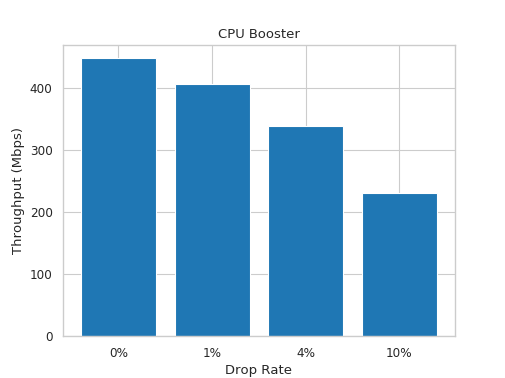

Text(0.5, 1.0, 'CPU Booster')

In [172]:
cpu_data = sorted(cpu_data, key= lambda x: x[0])
cpu_data
plt.figure()
ax = plt.subplot()
plt.bar(range(4),[c[1] for c in cpu_data])
plt.xticks(range(4))
ax.set_xticklabels('%d%%'%(c[0]*100)  for c in cpu_data)
plt.xlabel("Drop Rate")
plt.ylabel("Throughput (Mbps)")
plt.title("CPU Booster")

<IPython.core.display.Javascript object>


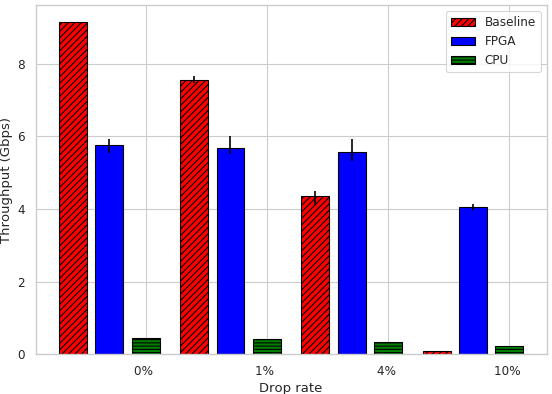

../iperf_output/fec/iperf_0.05_fec_2(10): 5723.726435115419 Mbps
../iperf_output/fec/iperf_0_fec_6(10): 5603.122256438012 Mbps
../iperf_output/fec/iperf_0.05_fec_1(10): 5581.557087521965 Mbps
../iperf_output/fec/iperf_0.02_fec_4(10): 5811.87592817425 Mbps
../iperf_output/fec/iperf_0.0001_fec_8(10): 5670.377006625393 Mbps
../iperf_output/fec/iperf_0.01_fec_1(10): 5672.82328244281 Mbps
../iperf_output/fec/iperf_0_fec_5(10): 5796.883099414639 Mbps
../iperf_output/fec/iperf_0.001_fec_4(10): 5756.973820144701 Mbps
../iperf_output/fec/iperf_0.04_fec_4(10): 5322.789867496786 Mbps
../iperf_output/fec/iperf_0_fec_8(10): 5762.70238260934 Mbps
../iperf_output/fec/iperf_0.1_fec_3(10): 4066.727001862815 Mbps
../iperf_output/fec/iperf_0.01_fec_10(10): 5509.157907536281 Mbps
../iperf_output/fec/iperf_0.04_fec_2(10): 5929.259268089499 Mbps
../iperf_output/fec/iperf_0.01_fec_3(10): 5694.832523386385 Mbps
../iperf_output/fec/iperf_0.1_fec_1(10): 3975.685840234535 Mbps
../iperf_output/fec/iperf_0.1_fec_6

../iperf_output/nofec/iperf_0.1_nofec_3(10): 95.61161645335308 Mbps
../iperf_output/nofec/iperf_0.03_nofec_3(10): 6705.6538539444955 Mbps
../iperf_output/nofec/iperf_0.02_nofec_3(10): 7420.633123291056 Mbps
../iperf_output/nofec/iperf_0_nofec_7(10): 9156.314825038162 Mbps
../iperf_output/nofec/iperf_0.001_nofec_2(10): 8790.188415245899 Mbps
../iperf_output/nofec/iperf_0.03_nofec_7(10): 6661.912406677282 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_10(10): 9152.965346962555 Mbps
../iperf_output/nofec/iperf_0_nofec_10(10): 9155.832857410667 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_6(10): 9153.928260360923 Mbps
../iperf_output/nofec/iperf_0.02_nofec_4(10): 7239.979737955893 Mbps
../iperf_output/nofec/iperf_0.001_nofec_3(10): 8735.898560335305 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_4(10): 9153.860168860569 Mbps
../iperf_output/nofec/iperf_0.04_nofec_3(10): 4384.501414444648 Mbps
../iperf_output/nofec/iperf_0.01_nofec_6(10): 7465.401487280508 Mbps
../iperf_output/nofec/iperf_0_

In [169]:
sns.set_context('notebook')

fec_files = glob('../iperf_output/fec/*')
nofec_files = glob('../iperf_output/nofec/*')
cpu_files = glob('../data/cpu_booster/*')

plt.figure(figsize=(7, 5))
make_cpu_plot(fec_files, nofec_files, cpu_files, textfile='fec_throughput.txt')
plt.tight_layout(pad=.1)
plt.savefig("tcp_throughput.pdf")

make_gray('tcp_throughput.pdf','tcp_throughput_gray.pdf')

<IPython.core.display.Javascript object>


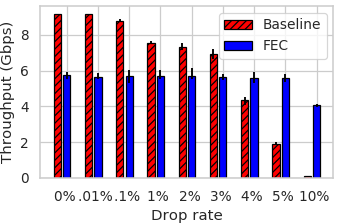

../iperf_output/fec/iperf_0.05_fec_2(10): 5723.726435115419 Mbps
../iperf_output/fec/iperf_0_fec_6(10): 5603.122256438012 Mbps
../iperf_output/fec/iperf_0.05_fec_1(10): 5581.557087521965 Mbps
../iperf_output/fec/iperf_0.02_fec_4(10): 5811.87592817425 Mbps
../iperf_output/fec/iperf_0.0001_fec_8(10): 5670.377006625393 Mbps
../iperf_output/fec/iperf_0.01_fec_1(10): 5672.82328244281 Mbps
../iperf_output/fec/iperf_0_fec_5(10): 5796.883099414639 Mbps
../iperf_output/fec/iperf_0.001_fec_4(10): 5756.973820144701 Mbps
../iperf_output/fec/iperf_0.04_fec_4(10): 5322.789867496786 Mbps
../iperf_output/fec/iperf_0_fec_8(10): 5762.70238260934 Mbps
../iperf_output/fec/iperf_0.1_fec_3(10): 4066.727001862815 Mbps
../iperf_output/fec/iperf_0.01_fec_10(10): 5509.157907536281 Mbps
../iperf_output/fec/iperf_0.04_fec_2(10): 5929.259268089499 Mbps
../iperf_output/fec/iperf_0.01_fec_3(10): 5694.832523386385 Mbps
../iperf_output/fec/iperf_0.1_fec_1(10): 3975.685840234535 Mbps
../iperf_output/fec/iperf_0.1_fec_6

../iperf_output/nofec/iperf_0.1_nofec_3(10): 95.61161645335308 Mbps
../iperf_output/nofec/iperf_0.03_nofec_3(10): 6705.6538539444955 Mbps
../iperf_output/nofec/iperf_0.02_nofec_3(10): 7420.633123291056 Mbps
../iperf_output/nofec/iperf_0_nofec_7(10): 9156.314825038162 Mbps
../iperf_output/nofec/iperf_0.001_nofec_2(10): 8790.188415245899 Mbps
../iperf_output/nofec/iperf_0.03_nofec_7(10): 6661.912406677282 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_10(10): 9152.965346962555 Mbps
../iperf_output/nofec/iperf_0_nofec_10(10): 9155.832857410667 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_6(10): 9153.928260360923 Mbps
../iperf_output/nofec/iperf_0.02_nofec_4(10): 7239.979737955893 Mbps
../iperf_output/nofec/iperf_0.001_nofec_3(10): 8735.898560335305 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_4(10): 9153.860168860569 Mbps
../iperf_output/nofec/iperf_0.04_nofec_3(10): 4384.501414444648 Mbps
../iperf_output/nofec/iperf_0.01_nofec_6(10): 7465.401487280508 Mbps
../iperf_output/nofec/iperf_0_

In [121]:
sns.set_context('notebook')

fec_files = glob('../iperf_output/fec/*')
nofec_files = glob('../iperf_output/nofec/*')

plt.figure(figsize=(3.8, 2.5))
make_plot(fec_files, nofec_files, textfile='fec_throughput.txt')
plt.tight_layout(pad=.1)
plt.savefig("tcp_throughput.pdf")

make_gray('tcp_throughput.pdf','tcp_throughput_gray.pdf')

<IPython.core.display.Javascript object>


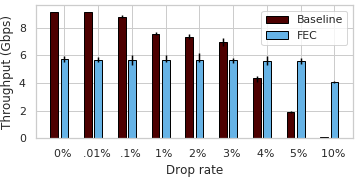

../iperf_output/fec/iperf_0.05_fec_2(10): 5723.726435115419 Mbps
../iperf_output/fec/iperf_0_fec_6(10): 5603.122256438012 Mbps
../iperf_output/fec/iperf_0.05_fec_1(10): 5581.557087521965 Mbps
../iperf_output/fec/iperf_0.02_fec_4(10): 5811.87592817425 Mbps
../iperf_output/fec/iperf_0.0001_fec_8(10): 5670.377006625393 Mbps
../iperf_output/fec/iperf_0.01_fec_1(10): 5672.82328244281 Mbps
../iperf_output/fec/iperf_0_fec_5(10): 5796.883099414639 Mbps
../iperf_output/fec/iperf_0.001_fec_4(10): 5756.973820144701 Mbps
../iperf_output/fec/iperf_0.04_fec_4(10): 5322.789867496786 Mbps
../iperf_output/fec/iperf_0_fec_8(10): 5762.70238260934 Mbps
../iperf_output/fec/iperf_0.1_fec_3(10): 4066.727001862815 Mbps
../iperf_output/fec/iperf_0.01_fec_10(10): 5509.157907536281 Mbps
../iperf_output/fec/iperf_0.04_fec_2(10): 5929.259268089499 Mbps
../iperf_output/fec/iperf_0.01_fec_3(10): 5694.832523386385 Mbps
../iperf_output/fec/iperf_0.1_fec_1(10): 3975.685840234535 Mbps
../iperf_output/fec/iperf_0.1_fec_6

../iperf_output/nofec/iperf_0.05_nofec_3(10): 1929.6598422346576 Mbps
../iperf_output/nofec/iperf_0.1_nofec_3(10): 95.61161645335308 Mbps
../iperf_output/nofec/iperf_0.03_nofec_3(10): 6705.6538539444955 Mbps
../iperf_output/nofec/iperf_0.02_nofec_3(10): 7420.633123291056 Mbps
../iperf_output/nofec/iperf_0_nofec_7(10): 9156.314825038162 Mbps
../iperf_output/nofec/iperf_0.001_nofec_2(10): 8790.188415245899 Mbps
../iperf_output/nofec/iperf_0.03_nofec_7(10): 6661.912406677282 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_10(10): 9152.965346962555 Mbps
../iperf_output/nofec/iperf_0_nofec_10(10): 9155.832857410667 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_6(10): 9153.928260360923 Mbps
../iperf_output/nofec/iperf_0.02_nofec_4(10): 7239.979737955893 Mbps
../iperf_output/nofec/iperf_0.001_nofec_3(10): 8735.898560335305 Mbps
../iperf_output/nofec/iperf_0.0001_nofec_4(10): 9153.860168860569 Mbps
../iperf_output/nofec/iperf_0.04_nofec_3(10): 4384.501414444648 Mbps
../iperf_output/nofec/iperf_0

In [112]:
sns.set_context('paper')

fec_files = glob('../iperf_output/fec/*')
nofec_files = glob('../iperf_output/nofec/*')

plt.figure(figsize=(4, 2))
make_plot(fec_files, nofec_files, textfile='fec_throughput.txt')
plt.tight_layout(pad=.1)
plt.savefig("tcp_throughput.pdf")

make_gray('tcp_throughput.pdf','tcp_throughput_gray.pdf')

In [13]:
5400 / 8700

0.6206896551724138